# <b><span style='color:#40a6bf'> RFM Analysis of Online Retail Data </span></b>

## EDA

In [816]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
from tqdm import tqdm
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
import squarify
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)                   # Show all columns
pd.set_option('display.max_rows', None)                      # Show all rows
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Limit decimal to 3 digits

In [818]:
# Reads an Excel file and assign each sheet to a new daraframe
df_0910 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_1011 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")
df_union = pd.concat([df_0910, df_1011])
df_union = df_union.reset_index(drop=True)

In [820]:
df = df_union.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [822]:
df.shape

(1067371, 8)

In [824]:
# Getting first impression on the data, noticed there are null values in the Description and Customer ID columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [828]:
# Checking if there are products priced at '0.00'
zero_price_products = df[df['Price'] == 0.00]
zero_price_products.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.00,NaN,United Kingdom


### Null and '0' Price Handling 

In [833]:
# Precentage of missing values in the Description and Customer ID columns
def null_precentages(dataframe, column):
    null_perc = (df[column].isnull().sum()/len(df[column]) * 100).round(2)
    return print("Missing Percentage of '{}': {}%".format(column, null_perc))
 
null_precentages(df, 'Description')
null_precentages(df, 'Customer ID')

Missing Percentage of 'Description': 0.41%
Missing Percentage of 'Customer ID': 22.77%


In [839]:
# Dropping rows with null values, as missing 'Description' data is minimal and
# 'Customer ID' is essential for this customer-based analysis

df.dropna(inplace=True)
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [841]:
# Verifiying
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [845]:
# Filtering '0' or negative price products  as they do not represent valid
# transactions and can skew financial analysis

df = df[df['Price'] > 0.001]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 824275 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824275 non-null  object        
 1   StockCode    824275 non-null  object        
 2   Description  824275 non-null  object        
 3   Quantity     824275 non-null  int64         
 4   InvoiceDate  824275 non-null  datetime64[ns]
 5   Price        824275 non-null  float64       
 6   Customer ID  824275 non-null  float64       
 7   Country      824275 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 56.6+ MB


###  Invoice Cancelation Handling

Refunded invoices must be dropped in order to ensure only completed transactions remain


In [849]:
# Isolation of refunds
df['Invoice'] = df['Invoice'].astype(str)
df_refunds = df[df['Invoice'].str.match('^[A-Za-z]')]
df_refunds.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia


In [851]:
df_refunds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18744 entries, 178 to 1067178
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      18744 non-null  object        
 1   StockCode    18744 non-null  object        
 2   Description  18744 non-null  object        
 3   Quantity     18744 non-null  int64         
 4   InvoiceDate  18744 non-null  datetime64[ns]
 5   Price        18744 non-null  float64       
 6   Customer ID  18744 non-null  float64       
 7   Country      18744 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.3+ MB


In [853]:
# Refunds are treated as negative quantities and are excluded from the analysis to
# keep purchasing behavior distinct from cancellation behavior. Since the percentage
# of canceled invoices is low and not significant, this data has been omitted for a
# more accurate assessment

# Calculation of precentage
print("Refunds percentage of total data: {}%".format(round(df_refunds.shape[0]/df.shape[0] * 100, 2)))

Refunds percentage of total data: 2.27%


In [906]:
# Additional filtering for any residual negative quantity products
df_filtered = df[df['Quantity'] > 0]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805531 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805531 non-null  object        
 1   StockCode    805531 non-null  object        
 2   Description  805531 non-null  object        
 3   Quantity     805531 non-null  int64         
 4   InvoiceDate  805531 non-null  datetime64[ns]
 5   Price        805531 non-null  float64       
 6   Customer ID  805531 non-null  float64       
 7   Country      805531 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


In [908]:
# Manual drop of the original invoice after cacnceling
drop_index = df_filtered[df_filtered['Description'] == "PAPER CRAFT , LITTLE BIRDIE"].index
df_filtered = df_filtered.drop(drop_index)

# Dropping irrelevant stock codes
df_filtered['StockCode'] = df_filtered['StockCode'].astype(str)
# Drop rows where 'StockCode' is in the stock_codes_to_drop list or starts with 'gift_'
stock_codes_to_drop = ['DOT', 'M', 'PADS', 'POST', 'S']
df_filtered = df_filtered.drop(df_filtered[df_filtered['StockCode'].isin(stock_codes_to_drop) | df_filtered['StockCode'].str.startswith('gift_')].index)

# Dropping rows where 'Description' starts with '*' followed by any character or '?' followed by any character
df_filtered = df_filtered.drop(df_filtered[df_filtered['Description'].str.match(r'^[\*\?].*')].index)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 802967 entries, 0 to 1067369
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      802967 non-null  object        
 1   StockCode    802967 non-null  object        
 2   Description  802967 non-null  object        
 3   Quantity     802967 non-null  int64         
 4   InvoiceDate  802967 non-null  datetime64[ns]
 5   Price        802967 non-null  float64       
 6   Customer ID  802967 non-null  float64       
 7   Country      802967 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.1+ MB


### EDA - Products

In [910]:
# Unique products
nuniue_product = df_filtered['Description'].nunique()
print("No. of unique products: {} \n".format(nuniue_product))

# Field calculation for products in the dataframe
product_summary = df_filtered.groupby('Description').agg(
    Product_Count = ('Description', 'size'),
    Total_Quantity = ('Quantity', 'sum'),
    Total_Revenue = ('Quantity', lambda x: (x * df_filtered.loc[x.index, 'Price']).sum())).reset_index()


top_10_products_count = product_summary.sort_values(by='Product_Count', ascending=False)

No. of unique products: 5278 



In [911]:
# Most popular products
# Calculate Avg_Quantity_per_Order
top_10_products_count['Avg_Quantity_per_Order'] = (
    top_10_products_count['Total_Quantity'] / top_10_products_count['Product_Count'])
top_10_products_count['Total_Rev_Prec'] = (top_10_products_count['Total_Revenue'] / top_10_products_count['Total_Revenue'].sum()) * 100

top_10_products_count = top_10_products_count.sort_values(by='Total_Revenue', ascending=False).head(10)
top_10_products_count

,Description,Product_Count,Total_Quantity,Total_Revenue,Avg_Quantity_per_Order,Total_Rev_Prec
3764,REGENCY CAKESTAND 3 TIER,3428,24899,286486.30,7.26,1.66
5042,WHITE HANGING HEART T-LIGHT HOLDER,5181,93640,252072.46,18.07,1.46
2391,JUMBO BAG RED RETROSPOT,2702,75759,136980.08,28.04,0.79
292,ASSORTED COLOUR BIRD ORNAMENT,2777,79913,127074.17,28.78,0.74
3151,PARTY BUNTING,2121,23607,103880.23,11.13,0.60
2694,MEDIUM CERAMIC TOP STORAGE JAR,198,77916,81416.73,393.52,0.47
3119,PAPER CHAIN KIT 50'S CHRISTMAS,1852,29477,79594.33,15.92,0.46
1004,CHILLI LIGHTS,960,15735,72860.14,16.39,0.42
509,BLACK RECORD COVER FRAME,556,19629,67209.44,35.30,0.39
2396,JUMBO BAG STRAWBERRY,1554,36098,64601.65,23.23,0.37


### <b><span style='color:#40a6bf'>Insights from Most Popular Across All Segments</span></b>
An analysis reveals that **4.98%** of total revenue is attributable to the top five products:

1. **Regency Cake 3 Tier**
    - Revenue Contribution: **1.66%**
    - Total Sales: **$286,486**
---

2. **White Hanging Heart T-Light Holder**
   - Revenue Contribution: **1.46%** 
   - Total Sales: **$252,072**
---

3. **Jumbo Bag Red Retrospot**
   - Revenue Contribution: **0.79%** 
   - Total Sales: **$136,980** 
   - **Above** Avarage Quantity (16.79) per Order: **28 units**
---

4. **Assorted Colour Bird Ornamentt**
   - Revenue Contribution: **0.74%** 
   - Total Sales: **$127,074** 
   - **Above** Average Quantity (16.79) per Order: **28 units**
---

5. **Party Bunting**
    - Revenue Contribution: **0.60%**
    - Total Sales: **$103,880**

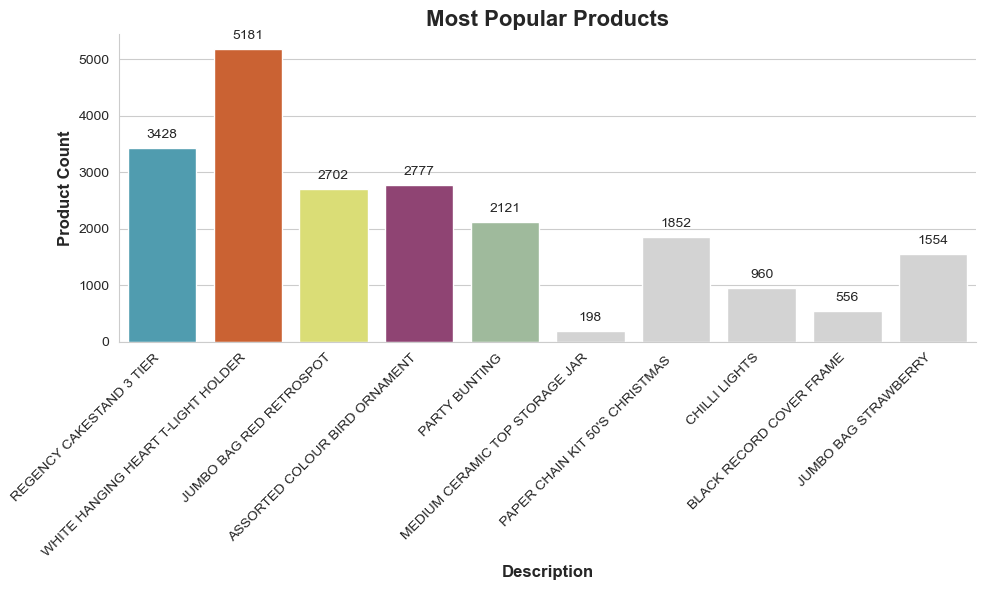

In [1150]:
# top_10_products_count bar plot
colors = ['#40a6bf', '#e3581a', '#eaee65','#9c3776','#9bbf97'] + ['lightgrey'] * (len(top_10_products_count) - 4)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Description', y='Product_Count', hue='Description', data=top_10_products_count, palette=colors)

plt.xticks(rotation=45, ha='right')

# Add count values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  # Format as integer
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the center top of the bar
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')  # Small vertical offset

sns.despine()
plt.xlabel('Description', fontsize=12, fontname='Arial', fontweight='bold')
plt.ylabel('Product Count', fontsize=12, fontname='Arial', fontweight='bold')
plt.title('Most Popular Products', fontsize=16, fontname='Arial', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

### EDA - Countries

In [916]:
# Unique countries
nunique_countries = df_filtered['Country'].nunique()
print("No. of distinct countries: {} \n".format(nunique_countries))

unique_countries = df_filtered['Country'].unique()
print("No. of distinct countries: {} \n".format(unique_countries))

# Countries summary with customer base size and revenue
country_customerbase = df_filtered.groupby('Country').agg(
    Customer_Base=('Customer ID', 'size'),
    Total_Revenue=('Quantity', lambda x: (x * df_filtered.loc[x.index, 'Price']).sum())).reset_index()

No. of distinct countries: 41 

No. of distinct countries: ['United Kingdom' 'France' 'Australia' 'EIRE' 'Germany' 'Portugal'
 'Denmark' 'Netherlands' 'Poland' 'Channel Islands' 'Spain' 'Cyprus'
 'Belgium' 'Greece' 'Norway' 'Austria' 'Sweden' 'United Arab Emirates'
 'Finland' 'Italy' 'Switzerland' 'USA' 'Japan' 'Unspecified' 'Nigeria'
 'Malta' 'RSA' 'Singapore' 'Bahrain' 'Thailand' 'Israel' 'Lithuania'
 'West Indies' 'Korea' 'Brazil' 'Canada' 'Iceland' 'Lebanon'
 'Saudi Arabia' 'Czech Republic' 'European Community'] 



In [917]:
# Excluding entries with an unspecified country, ensuring the data set contains only relevant and valid country
df_filtered.drop(df_filtered[df_filtered['Country'] == 'Unspecified'].index, inplace=True)

In [918]:
country_sorted = country_customerbase.sort_values(by='Customer_Base', ascending=False).head(10)
country_sorted

,Country,Customer_Base,Total_Revenue
38,United Kingdom,724558,14459797.54
14,Germany,16037,388959.99
10,EIRE,15719,602073.00
13,France,13327,315714.40
24,Netherlands,4983,549952.66
32,Spain,3620,98840.54
34,Switzerland,2956,93624.34
3,Belgium,2923,57322.77
28,Portugal,2382,48205.76
0,Australia,1806,168484.66


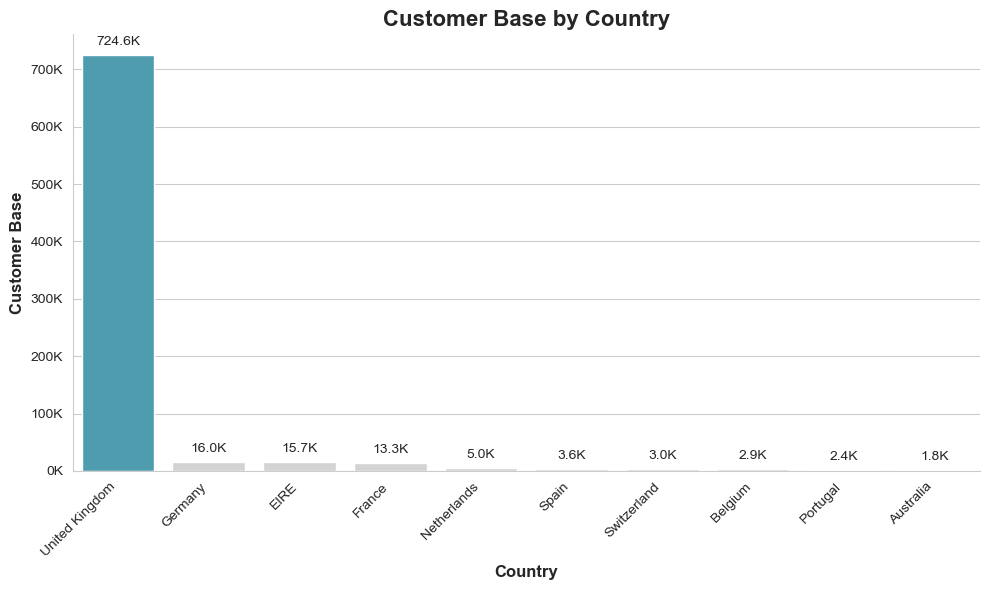

In [919]:
# top_10_products_count bar plot
country_sorted = country_sorted.sort_values(by='Customer_Base', ascending=False)
colors = ['#40a6bf'] + ['lightgrey'] * (len(country_sorted) - 1)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Country', y='Customer_Base', hue='Country', data=country_sorted, palette=colors)

plt.xticks(rotation=45, ha='right')

# Add count values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height() / 1e3, '.1f') + 'K',  # Format as integer
                (p.get_x() + p.get_width() / 2., p.get_height()),                     # Position at the center top of the bar
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')  # Small vertical offset

sns.despine()
plt.xlabel('Country', fontsize=12, fontname='Arial', fontweight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1e3:.0f}K'))

plt.ylabel('Customer Base', fontsize=12, fontname='Arial', fontweight='bold')
plt.title('Customer Base by Country', fontsize=16, fontname='Arial', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()

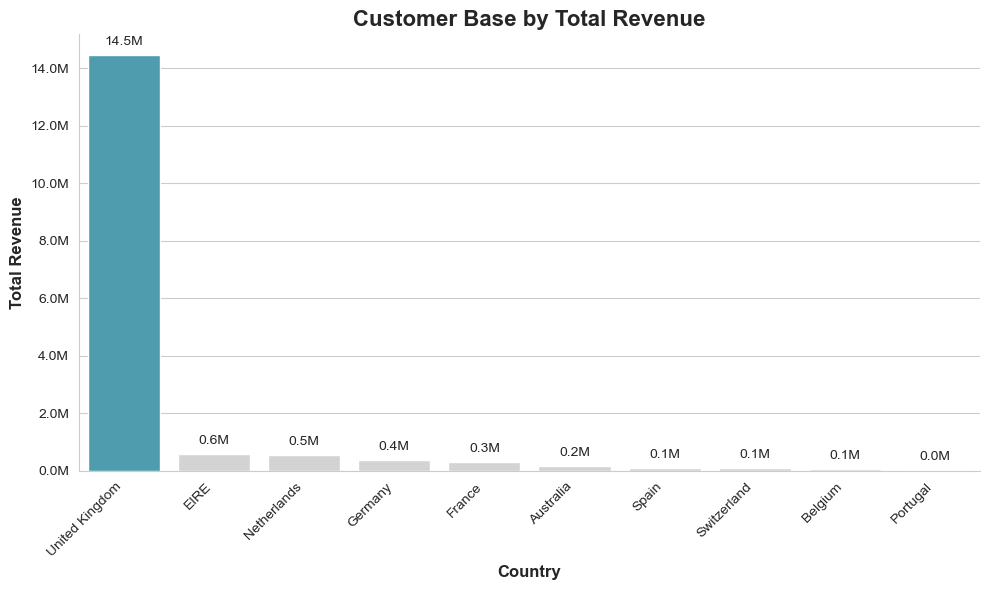

In [922]:
# Sort the DataFrame by 'Total_Revenue' in descending order
country_sorted = country_sorted.sort_values(by='Total_Revenue', ascending=False)

colors = ['#40a6bf'] + ['lightgrey'] * (len(country_sorted) - 1)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Country', y='Total_Revenue', hue='Country', data=country_sorted, palette=colors)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add count values on top of the bars in millions
for p in ax.patches:
    ax.annotate(format(p.get_height() / 1e6, '.1f') + 'M',  # Format as millions
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the center top of the bar
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')  # Small vertical offset

sns.despine()
plt.xlabel('Country', fontsize=12, fontname='Arial', fontweight='bold')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

plt.ylabel('Total Revenue', fontsize=12, fontname='Arial', fontweight='bold')
plt.title('Customer Base by Total Revenue', fontsize=16, fontname='Arial', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()


### <b><span style='color:#40a6bf'>Insights from Country Information Across All Segments</span></b>

The United Kingdom exhibits the largest customer base, which aligns with the dataset's focus on transactions from a UK-based, non-store online retail entity. Notably, the five countries with the highest customer bases also represent the primary contributors to total revenue. The UK accounts for an impressive 86% of overall earnings, while each of the other countries contributes approximately 3%. This distribution underscores the UK’s dominant position in the online retail landscape.

### EDA - Invocies

In [929]:
# Unique invoices
unique_invoices = df_filtered['Invoice'].nunique()
print("No. of distinct invoices: {} \n".format(unique_invoices))

# Total revenue of each invoice
invoice_revenue = df_filtered.groupby('Invoice').agg(Total_Revenue=('Quantity', lambda x: (x * df_filtered.loc[x.index, 'Price']).sum()))
invoice_revenue.sort_values(by='Total_Revenue', ascending=False).head(5)

No. of distinct invoices: 36663 



,Total_Revenue
Invoice,
541431,77183.60
493819,44051.60
556444,38970.00
524181,33167.80
537659,31770.98


## EDA business performance

Analyzing total sales by month, day of the week, and hour offers critical insights into customer behavior and operational performance. A monthly sales breakdown enables the identification of seasonal trends, allowing businesses to optimize marketing efforts and inventory management. Grouping sales by day of the week uncovers patterns in consumer activity, providing the basis for more effective promotions and staffing decisions. Hourly sales analysis pinpoints peak demand periods, facilitating improved workforce planning and resource allocation.

In [933]:
# Group assigning based on cutoff date
cutoff_date = pd.to_datetime('2010-12-01')
df_filtered.loc[:, 'Date Group'] = np.where(df_filtered['InvoiceDate'] <= cutoff_date, 1, 2)

# Calculate total sales
df_filtered.loc[:, 'Total Sales'] = df_filtered['Quantity'] * df_filtered['Price']

# Adding Year, Month, DayOfWeek and Hour coulmns
df_filtered.loc[:, 'Year'] = df_filtered['InvoiceDate'].dt.year
df_filtered.loc[:, 'Month'] = df_filtered['InvoiceDate'].dt.month
df_filtered.loc[:, 'DayOfWeek'] = df_filtered['InvoiceDate'].dt.strftime('%a')
df_filtered.loc[:, 'Hour'] = df_filtered['InvoiceDate'].dt.hour

df_filtered.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date Group,Total Sales,Year,Month,DayOfWeek,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,1,83.40,2009,12,Tue,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,1,81.00,2009,12,Tue,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,1,81.00,2009,12,Tue,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,1,100.80,2009,12,Tue,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,1,30.00,2009,12,Tue,7


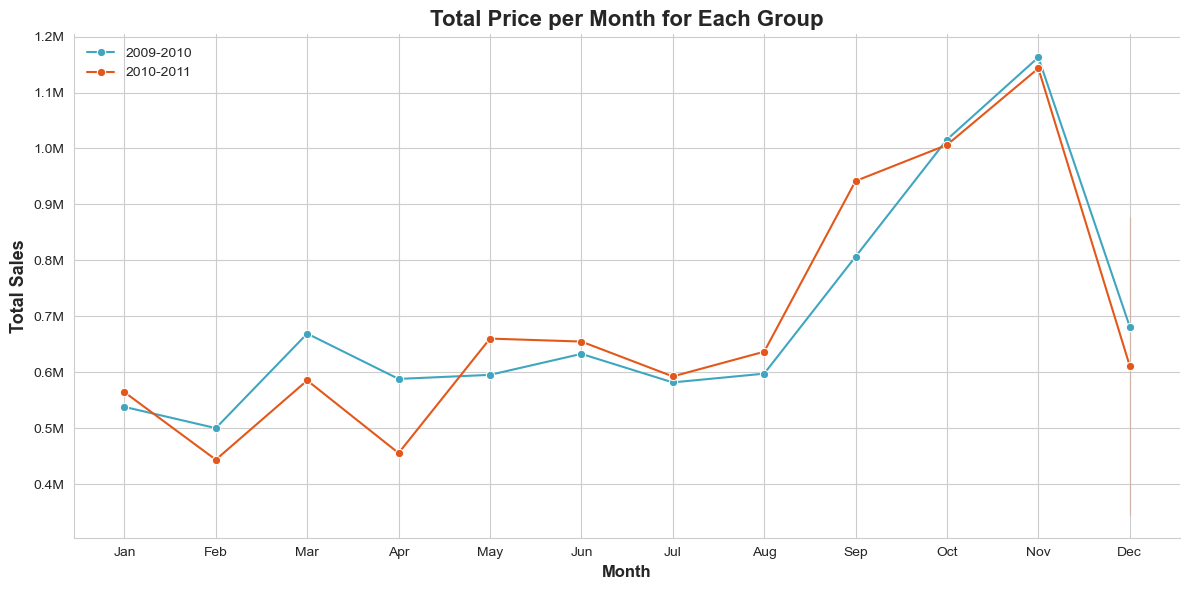

In [936]:
# Add 'Date Group' column based on cutoff date
cutoff_date = pd.to_datetime('2010-12-01')
df_filtered.loc[:, 'Date Group'] = df_filtered['InvoiceDate'].apply(lambda x: '2009-2010' if x <= cutoff_date else '2010-2011')

# Aggregate total price by year group and month
monthly_sales = df_filtered.groupby(['Date Group', 'Year', 'Month'])['Total Sales'].sum().reset_index()

# Plot total price per month for each group
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Total Sales', hue='Date Group', palette={'2009-2010': '#40a6bf', '2010-2011': '#e3581a'}, marker='o')

plt.title('Total Price per Month for Each Group', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Total Sales', fontsize=13, fontweight='bold')

# Customize x-axis ticks to show all months
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(ticks=range(1, 13), labels=month_labels)

# Format y-axis to show values in thousands
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

# Reposition legend
plt.legend(loc='upper left', frameon=False)

sns.despine()
plt.tight_layout()
plt.show()

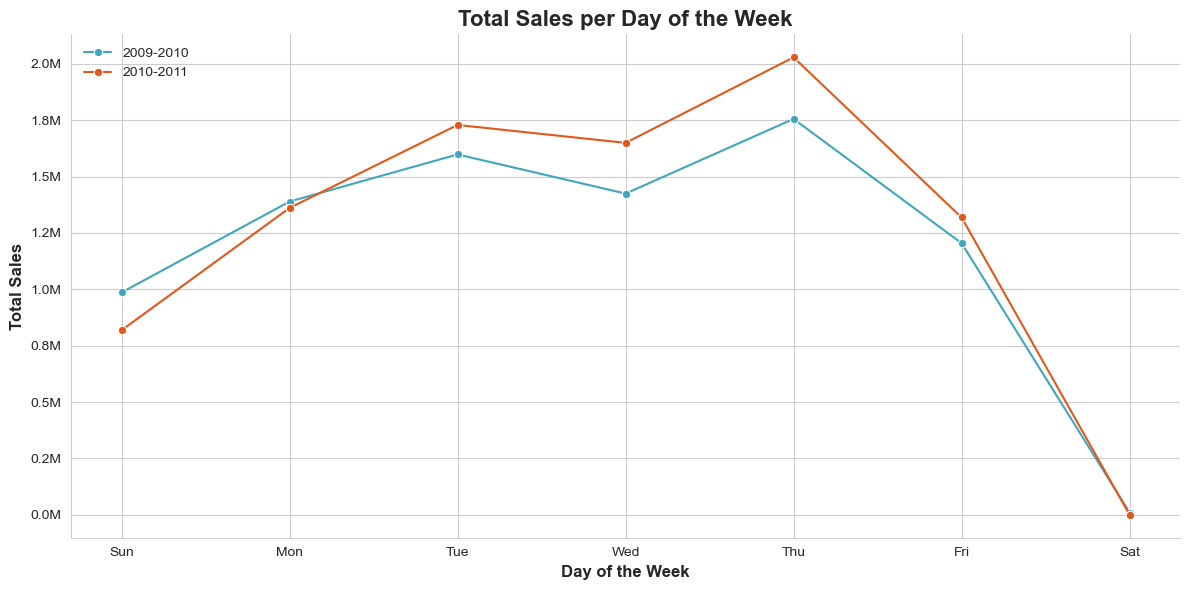

In [937]:
# Define the order of days of the week
day_order = ['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Convert 'DayOfWeek' to a categorical type with the defined order
df_filtered['DayOfWeek'] = pd.Categorical(
    df_filtered['DayOfWeek'], 
    categories=day_order, 
    ordered=True)

# Aggregate total sales by day of the week for each group
sales_by_dayofweek = df_filtered.groupby(['Date Group', 'DayOfWeek'], observed=False)['Total Sales'].sum().reset_index()

# Plot total sales per day of the week for each group
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sales_by_dayofweek,
    x='DayOfWeek',
    y='Total Sales',
    hue='Date Group',
    palette={'2009-2010': '#40a6bf', '2010-2011': '#e3581a'},
    marker='o')

plt.title('Total Sales per Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Total Sales', fontsize=12, fontweight='bold')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(len(day_order)))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

# Reposition legend
plt.legend(loc='upper left', frameon=False)

# Remove black box around the plot
sns.despine()

plt.tight_layout()
plt.show()

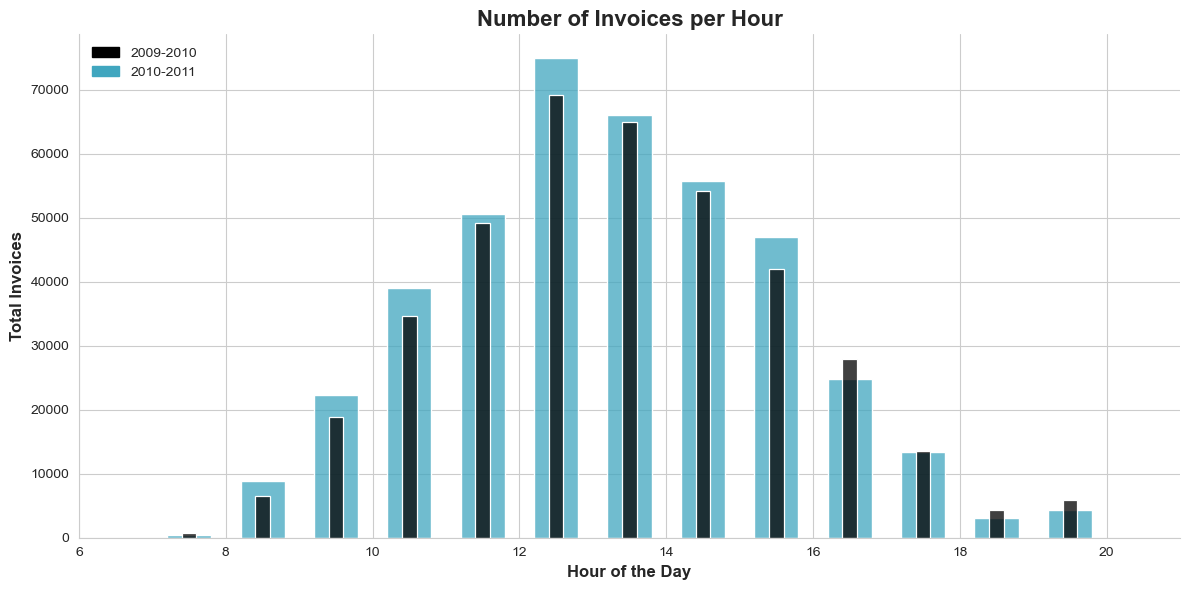

In [940]:
# Set the style
sns.set_style("whitegrid")

# Plot the histogram for 2010-2011
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_filtered[df_filtered['Date Group'] == '2010-2011'],
    x='Hour',
    color='#40a6bf',
    shrink=0.6,
    binwidth=1,  # Set bin width for both plots
    label='2010-2011'
)

# Plot the histogram for 2009-2010
sns.histplot(
    data=df_filtered[df_filtered['Date Group'] == '2009-2010'],
    x='Hour',
    color='black',
    binwidth=1,  # Same bin width for consistency
    shrink=0.2,  # Shrink only the bars of 2009-2010
    label='2009-2010'
)
plt.title('Number of Invoices per Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=12, fontweight='bold')
plt.ylabel('Total Invoices', fontsize=12, fontweight='bold')

# Set x-axis limits from 6 to 21
plt.xlim(6, 21)

# Reposition legend
legend_patches = [
    Patch(color='black', label='2009-2010'),
    Patch(color='#40a6bf', label='2010-2011')]
plt.legend(handles=legend_patches, loc='upper left', frameon=False)

# Remove black box around the plot
sns.despine()

plt.tight_layout()
plt.show()

### <b><span style='color:#40a6bf'>Insights into business performance</span></b>

The total monthly sales across each year range exhibit consistent seasonal behavior. Notably, the performance for the period of 2010-2011 demonstrates an increase in total sales from May to October. An analysis of daily sales reveals a predictable growth in orders from Sunday to Thursday, with Thursday representing the peak sales day. Conversely, Saturday shows negligible order activity.

From a year-over-year perspective, the overall performance in 2010-2011 is superior throughout the week. In terms of hourly invoice distribution, peak order volume occurs between 12 PM and 3 PM. When comparing the two-year ranges, there is an overall increase in incoming invoices between 9 AM and 3 PM, while there are fewer invoices recorded before 8 AM and after 6 PM.


## RFM Analysis

### Metrics and Scores

In [973]:
# Remove '.00' and convert to object
df_filtered['Customer ID'] = df_filtered['Customer ID'].apply(lambda x: str(int(x)) if isinstance(x, float) else str(x))

# Ensure that 'InvoiceDate' is in datetime format first
df_filtered['InvoiceDate'] = pd.to_datetime(df_filtered['InvoiceDate'], errors='coerce')

# Then convert 'InvoiceDate' to date-only
df_filtered['InvoiceDate'] = df_filtered['InvoiceDate'].dt.date

# Set a reference date and make it date-only
today_date = dt.datetime(2011, 12, 11).date()

# Group by customer ID and calculate Recency, Frequency, and Monetary metrics
df_rfm = df_filtered.groupby('Customer ID').agg(
        {'InvoiceDate': lambda date: (today_date - date.max()).days,  # Recency
         'Invoice': 'nunique',                                       # Frequency
         'Total Sales': 'sum'})                                      # Monetary

# Rename the columns for clarity
df_rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Check the result
df_rfm.head(10)

,Recency,Frequency,Monetary
Customer ID,,,
12346,327,12,77556.46
12347,4,8,5633.32
12348,77,5,1658.40
12349,20,3,3678.69
12350,312,1,294.40
12352,38,9,1729.54
12353,206,2,406.76
12354,234,1,1079.40
12355,216,2,947.61


In [974]:
# Calculate scores based on quantiles, assigning labels from 1 to 5 (1 being lowest recency)
df_rfm["Recency_Score"] = pd.qcut(df_rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
df_rfm["Frequency_Score"] = pd.qcut(df_rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
df_rfm["Monetary_Score"] = pd.qcut(df_rfm["Monetary"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

df_rfm.head(5)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
Customer ID,,,,,,
12346,327,12,77556.46,2,5,5
12347,4,8,5633.32,5,4,5
12348,77,5,1658.40,3,4,4
12349,20,3,3678.69,5,3,5
12350,312,1,294.40,2,1,2


### Recency-Frequency-Monetary segment

In [978]:
# Combine recency and frequency scores to create RFM segment
df_rfm['RFM_Segment'] = df_rfm['Recency_Score'].astype(str) + df_rfm['Frequency_Score'].astype(str) + df_rfm['Monetary_Score'].astype(str)
df_rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment
Customer ID,,,,,,,
12346,327,12,77556.46,2,5,5,255
12347,4,8,5633.32,5,4,5,545
12348,77,5,1658.40,3,4,4,344
12349,20,3,3678.69,5,3,5,535
12350,312,1,294.40,2,1,2,212


In [987]:
# Combine recency and recency scores to create RFM segment
df_rfm = df_rfm.astype({
    'Recency_Score'  : 'int',
    'Frequency_Score': 'int',
    'Monetary_Score' : 'int',  
    'RFM_Segment'    : 'int'})

# Create some human friendly labels for the scores
seg_map = {
r'[1-2][1-2]': 'hibernating',
r'[1-2][3-4]': 'at_risk',
r'[1-2]5': 'cant_loose',
r'3[1-2]': 'about_to_sleep',
r'33': 'need_attention',
r'[3-4][4-5]': 'loyal_customers',
r'41': 'promising',
r'51': 'new_customers',
r'[4-5][2-3]': 'potential_loyalists',
r'5[4-5]': 'champions'}

# Combine Recency, Frequency, and Monetary scores into a string for mapping
df_rfm['RFM_Segment_Label'] = (df_rfm['Recency_Score'].map(str) + df_rfm['Frequency_Score'].map(str)).replace(seg_map, regex=True)

df_rfm.index = df_rfm.index.astype(int)  # Convert index to integer
df_rfm.head(5)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Segment,RFM_Segment_Label
Customer ID,,,,,,,,
12346,327,12,77556.46,2,5,5,255,cant_loose
12347,4,8,5633.32,5,4,5,545,champions
12348,77,5,1658.40,3,4,4,344,loyal_customers
12349,20,3,3678.69,5,3,5,535,potential_loyalists
12350,312,1,294.40,2,1,2,212,hibernating


### RFM Segment Analysis

In [992]:
print(df_rfm['RFM_Segment_Label'].value_counts())

RFM_Segment_Label
hibernating            1515
loyal_customers        1136
champions               850
at_risk                 753
potential_loyalists     713
about_to_sleep          382
need_attention          267
promising               111
cant_loose               72
new_customers            57
Name: count, dtype: int64


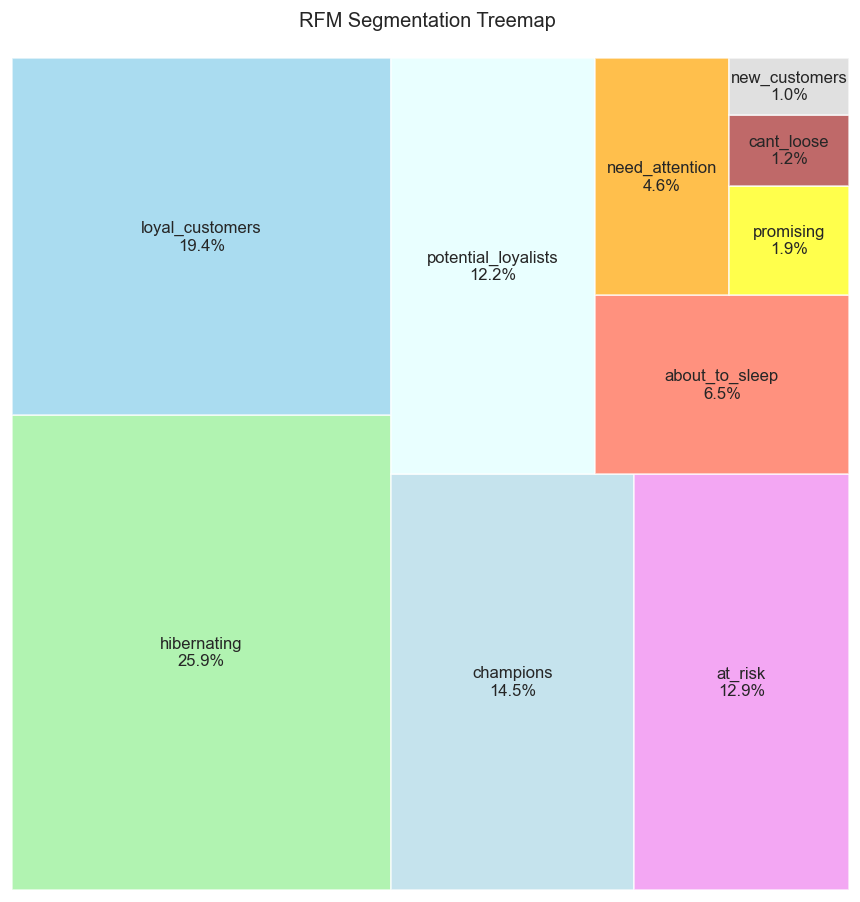

In [1060]:
segment_sizes = pd.Series(df_rfm['RFM_Segment_Label'].value_counts())

labels = segment_sizes.index.tolist()  # Segment names
counts = segment_sizes.values.tolist() # Segment count

# Add presentage to each segment
total_count = sum(counts)
percentages = [(cnt / total_count) * 100 for cnt in counts]
labels = [f'{labels}\n{percentage:.1f}%' for labels, percentage in zip(labels, percentages)]

sizes = segment_sizes.values.tolist()   # Sizes based on count
colors = ['lightgreen', 'skyblue', 'lightblue', 'violet', 'lightcyan',
          'tomato', 'orange', 'yellow', 'brown', 'lightgrey'][:len(labels)]  # Adjust the number of colors

plt.figure(figsize=(9, 9), dpi=120)  # Adjust the figure size and DPI for better visualization

# Plot the treemap
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.7)

# Add title
plt.title('RFM Segmentation Treemap \n')

# Display the plot
plt.axis('off')  # Enable axis for reference
plt.show()

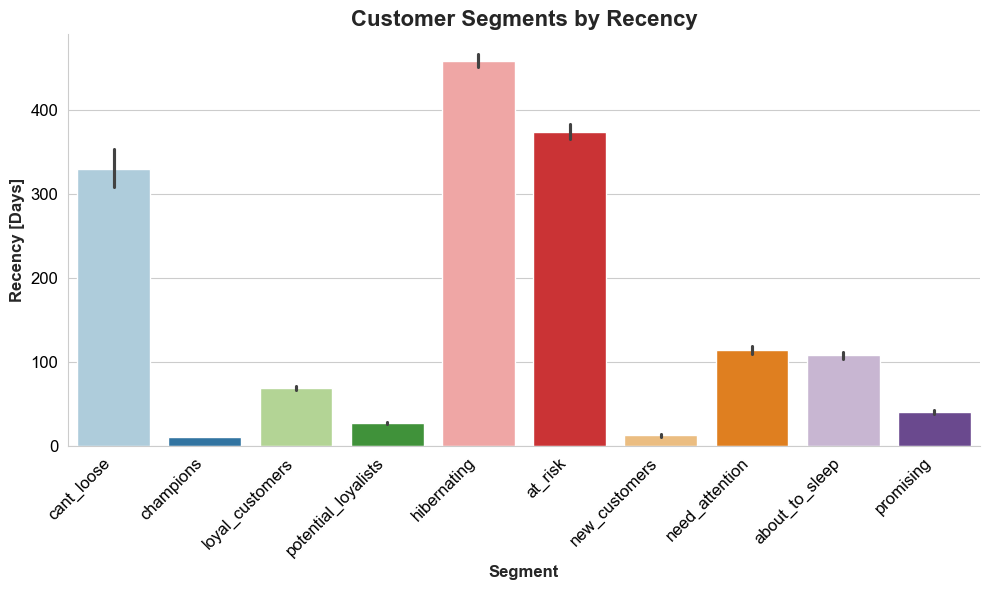

In [1129]:
# Customer Segments by Recency).reset_index()
colors = sns.color_palette("Paired")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="RFM_Segment_Label", y="Recency", data=df_rfm, palette=colors)

sns.despine()

plt.title('Customer Segments by Recency', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12, fontweight='bold')
plt.ylabel('Recency [Days]', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

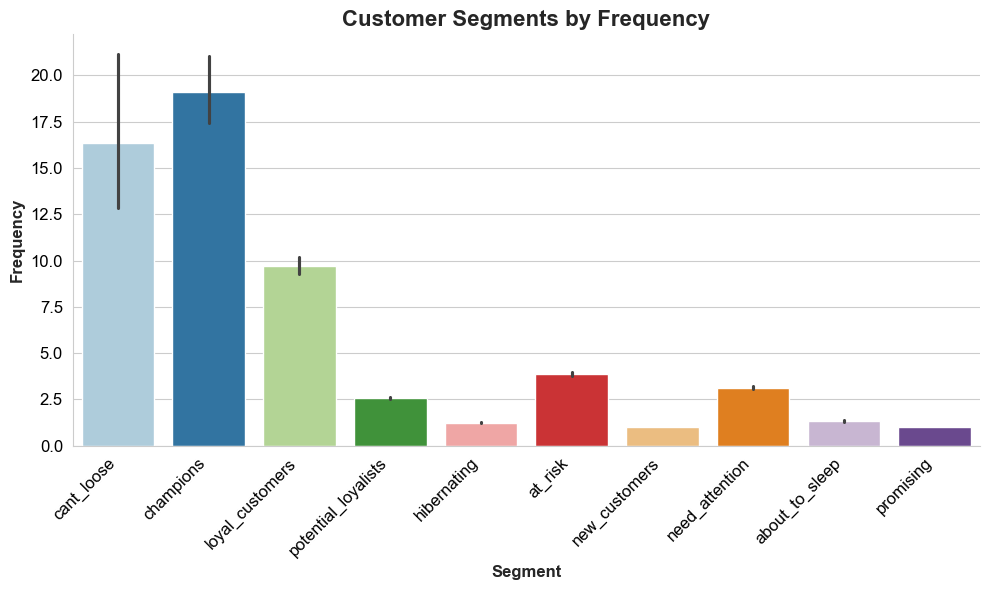

In [1123]:
# Customer Segments by Frequency
colors = sns.color_palette("Paired")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="RFM_Segment_Label", y="Frequency", data=df_rfm, palette=colors)

sns.despine()

plt.title('Customer Segments by Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

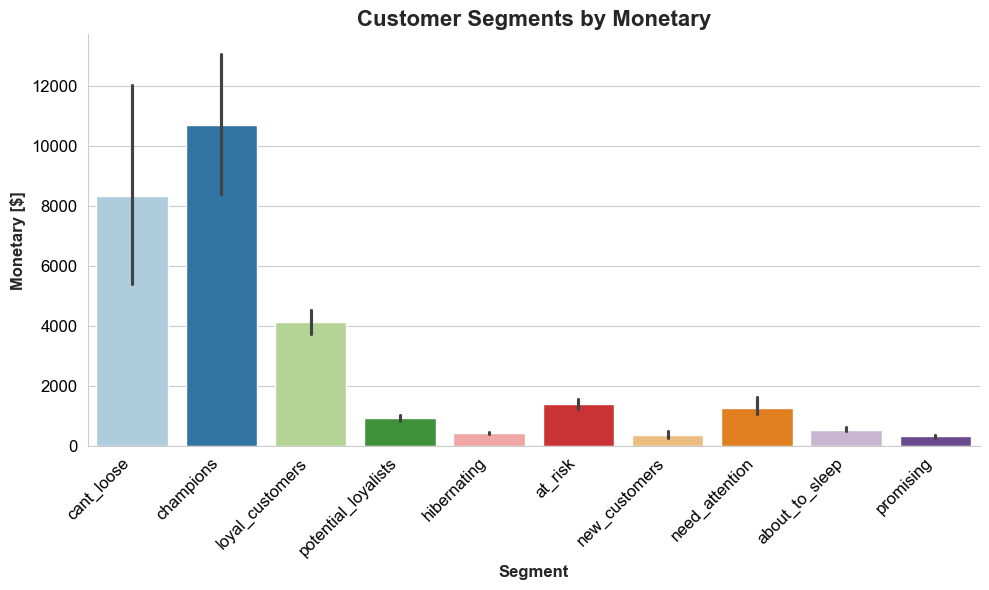

In [1127]:
# Customer Segments by Monetary
colors = sns.color_palette("Paired")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="RFM_Segment_Label", y="Monetary", data=df_rfm, palette=colors)

sns.despine()

plt.title('Customer Segments by Monetary', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12, fontweight='bold')
plt.ylabel('Monetary [$]', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

In [1062]:
# Statistics of segments by recency, frequancy and monetary mean, count and sum
df_segmented = df_rfm.groupby("RFM_Segment_Label").agg({
    'Recency': ['mean', 'count'],
    'Frequency': ['mean', 'sum'],
    'Monetary': ['mean', 'sum']})

df_segmented =df_segmented.sort_values(by=('Monetary', 'sum'), ascending=False)
df_segmented

Recency       Frequency        Monetary           
                       mean count      mean    sum     mean        sum
RFM_Segment_Label                                                     
champions             10.27   850     19.10  16239 10690.73 9087116.47
loyal_customers       69.05  1136      9.73  11057  4107.64 4666277.24
at_risk              374.39   753      3.90   2935  1377.71 1037417.24
potential_loyalists   27.28   713      2.58   1841   920.75  656491.89
hibernating          459.38  1515      1.25   1891   415.46  629418.16
cant_loose           330.31    72     16.33   1176  8315.15  598690.75
need_attention       114.19   267      3.14    839  1269.14  338859.29
about_to_sleep       107.67   382      1.35    517   540.28  206386.55
promising             40.29   111      1.00    111   316.96   35182.34
new_customers         12.40    57      1.00     57   345.54   19696.01

In [1080]:
# Precentages of customers of each segment

counts = df_rfm['RFM_Segment_Label'].value_counts()
   
# Convert to DataFrame
df_segment = counts.reset_index()
df_segment.columns = ['RFM_Segment_Label', 'Count']
    
# Calculate total and percentage
total_count = df_segment['Count'].sum()
df_segment['Percentage'] = (df_segment['Count'] / total_count) * 100 
df_segment

,RFM_Segment_Label,Count,Percentage
0,hibernating,1515,25.87
1,loyal_customers,1136,19.40
2,champions,850,14.52
3,at_risk,753,12.86
4,potential_loyalists,713,12.18
5,about_to_sleep,382,6.52
6,need_attention,267,4.56
7,promising,111,1.90
8,cant_loose,72,1.23
9,new_customers,57,0.97


### <b><span style='color:#40a6bf'>RFM Segmentation Recommendations</span></b>

### Overall Performance Patterns
The relationship between recency and monetary contribution suggests that segments with shorter recency tend to generate higher revenue. Focusing on reducing the recency of at-risk segments may lead to increased overall revenue.

### Segment Summaries

#### 1. **Champions** - 14.52% of Customers
- **Mean Recency**: 10.27 days  
- **Mean Frequency**: 19.10 (with 16,239 purchases)  
- **Mean Monetary**: $9,087,116.47  

*Bought recently, purchase often, and spent the most money.*

**Recommendations:**
- **Loyalty Programs**: Offer exclusive rewards for continued purchases.
- **VIP Events**: Invite them to special sales events.
- **Personalized Thank You Notes**: Express gratitude for their loyalty.

---

#### 2. **Loyal Customers** - 19.40% of Customers
- **Mean Recency**: 69.05 days  
- **Mean Frequency**: 9.73 (with 11,057 purchases)  
- **Mean Monetary**: $4,666,277.24  

*Purchase frequently, spent significantly, but recency is increasing.*

**Recommendations:**
- **Targeted Offers**: Send exclusive discounts to encourage more purchases.
- **Referral Programs**: Incentivize referrals with rewards.

---

#### 3. **At Risk** - 12.86% of Customers
- **Mean Recency**: 374.39 days  
- **Mean Frequency**: 3.90 (with 2,935 purchases)  
- **Mean Monetary**: $1,037,417.24  

*Inactive recently, previously spent well, need re-engagement efforts.*

**Recommendations:**
- **Win-Back Campaign**: Offer 20% off next order, valid for 7 days.
- **Feedback Requests**: Solicit feedback to understand reduced engagement.

---

#### 4. **Potential Loyalists** - 5.87% of Customers
- **Mean Recency**: 27.28 days  
- **Mean Frequency**: 2.58 (with 1,841 purchases)  
- **Mean Monetary**: $656,491.89  

*Bought recently, moderate frequency, nurturing can enhance spending.*

**Recommendations:**
- **Personalized Recommendations**: Tailor product suggestions based on interests.
- **Loyalty Points Introduction**: Offer double points on the next purchase.

---

#### 5. **Hibernating** - 25.87% of Customers
- **Mean Recency**: 459.38 days  
- **Mean Frequency**: 1.25 (with 1,891 purchases)  
- **Mean Monetary**: $629,418.16  

*Long-term inactive, low spenders, need targeted re-engagement.*

**Recommendations:**
- **Re-engagement Campaign**: Targeted email with a special offer.
- **Exclusive Access**: Early access to new arrivals.

---

#### 6. **Can't Lose** - 1.23% of Customers
- **Mean Recency**: 330.31 days  
- **Mean Frequency**: 16.33 (with 1,176 purchases)  
- **Mean Monetary**: $598,690.75  

*Didn't buy recently, decent frequency, must engage to maintain loyalty.*

**Recommendations:**
- **Compelling Offers**: Tailored promotions to encourage re-engagement.
- **Loyalty Program Benefits**: Highlight loyalty program advantages.

---

#### 7. **Need Attention** - 4.56% of Customers
- **Mean Recency**: 114.19 days  
- **Mean Frequency**: 3.14 (with 839 purchases)  
- **Mean Monetary**: $338,859.29  

*Low frequency and recent purchases, require engagement to boost activity.*

**Recommendations:**
- **Personalized Offers**: Customized discounts or products.
- **Engagement Campaigns**: Use surveys for feedback.

---

#### 8. **About to Sleep** - 6.52% of Customers
- **Mean Recency**: 107.67 days  
- **Mean Frequency**: 1.35 (with 517 purchases)  
- **Mean Monetary**: $206,386.55  

*Low recency, increasing frequency, urgent re-engagement needed.*

**Recommendations:**
- **Reminder Emails**: Friendly reminders about previous interests.
- **Incentivized Engagement**: Discounts for any interaction.

---

#### 9. **Promising** - 1.90% of Customers
- **Mean Recency**: 40.29 days  
- **Mean Frequency**: 1.00 (with 111 purchases)  
- **Mean Monetary**: $35,182.34  

*Bought recently but low spending; nurturing can increase future purchases.*

**Recommendations:**
- **Welcome Series**: Nurturing onboarding email campaign.
- **Exclusive Promotions**: Unique offers to encourage a second purchase.

---

#### 10. **New Customers** - 0.97% of Customers
- **Mean Recency**: 12.40 days  
- **Mean Frequency**: 1.00 (with 57 purchases)  
- **Mean Monetary**: $19,696.01  

*Recent purchases, onboarding support needed for repeat buying encouragement.*

**Recommendations:**
- **Onboarding Campaign**: Welcome email series with a discount.
- **Interactive Guides**: Tutorials on using their first purchase.
